# Histogram processing in Coffea

While `coffea` provides its own [`coffea.hist`][coffeahist] package, to better
interface with the python ecosystem in general, I recommend users to start
their analysis using the [`scikit hist`][scikithist] package, as it is more
general purpose, and coffea histogram will be depreciated in newer version of
`coffea`. All the core functionalities would be the same, but `sckikit hist`
(which we will refer to as just `hist` for the remainder of this tutorial) has
more bells and whistles out of the box. A very good documentation on using
`hist` is already provided by the developers [here][scikithist], so this
documentation would mainly focus on going over the fundamental concepts of
using histogram for physics analysis. 

One thing that will not be included in this documentation would be the plotting
of histogram, as there are much too many customization options to go over. Here
we will be using the in-built `Hist.plot1d` and `Hist.plot2d` with minimal
styling settings, just to illustrate how the data in the histogram are being
stored.  

Let us start by importing the basic libraries that we will be using: `hist` and
`numpy` (`numpy` would mainly be used for pseudo-data generation and nothing
else.)


[coffeahist]: https://coffeateam.github.io/coffea/api/coffea.hist.Hist.html
[scikithist]: https://hist.readthedocs.io/en/latest/?badge=latest

In [30]:
import hist 
import numpy as np
import matplotlib.pyplot as plt

## Histogram construction in computation

Histograms in the context of an analysis is typically used to tally the number
of entities that fall under some "discrete" criteria. These criteria can either
be some true discrete variable (like data sets/particle flavor), or some
continuous variable that we explicitly discrete-ize (like for particle kinematic
variables). Let use make a very simple histogram that represents the 3 particle
kinematic variables used in HEP: $p_{T}$, $\eta$ and $\phi$:

The filling of the histogram can be done in parallel, supposing that you have
arrays of identical dimensions. 


In [14]:
h = hist.Hist(hist.axis.Regular(100, 20, 100, name='pt'),
              hist.axis.Regular(100, -3, 3, name='eta'),
              hist.axis.Regular(100, -np.pi, np.pi, name='phi'))

N = 10_000_000
pt = np.random.exponential(50, size=N)
eta = np.random.normal(size=N)
phi = np.random.uniform(-np.pi, np.pi, size=N)
h.fill(pt=pt, eta=eta, phi=phi)


Hist(
  Regular(100, 20, 100, name='pt', label='pt'),
  Regular(100, -3, 3, name='eta', label='eta'),
  Regular(100, -3.14159, 3.14159, name='phi', label='phi'),
  storage=Double()) # Sum: 5334785.0 (10000000.0 with flow)

For a computer, a histogram is just an array of values, indicating the number of
entries that was filling in "bin". Formally, the `hist` package uses what is
known as the ["unified histogram interface notation" (UHI)][uhi], so the
following

[uhi]: https://uhi.readthedocs.io/en/latest/


In [15]:
h[0, 50, 15]


20.0

Simply indicates the histogram value stored in the 0-th bin of the $p_T$-axis,
the 50-th bin of the $\eta$-axis, and the 15-th bin of the $\phi$ axis.

As working with raw bin indices is rather cumbersome, the UHI notation allows the
use of `j` as a postfix to indicate that one want the bin that contains some
numerical value, for instance:



In [17]:
h[25j, 0.5j, -1.2j]

26.0

Would indicate the histogram value of the bin that contains $p_{T}$ value 25,
$\eta$ value 0.5 and $\phi$ of value -1.2.

Here we are treating the histogram as an array, knowing that the first index
corresponds to the $p_{T}$ UHI bin index, the second corresponding to the $\eta$
UHI bin index and so on. As long as one has declared the histogram axis with a
name, a dictionary can also be used to explicitly specify the bin index for some
named axis, rather than having to keep track of the axis ordering manually. For
example the two expressions below

In [18]:
print(h[25j, 0.5j, -1.2j])
print(h[{'phi': -1.2j, 'pt': 25j, 'eta': 0.5j}])


26.0
26.0


Means entirely the same UHI index, just one is much more human friendly with
more explicitly notations of which bins are being requested without needed to
tracking the axis ordering. 


## Histogram slicing and truncation

Very rarely will we need to operate directly on raw histogram values. Most of
the time, the rationale for using a high dimensional histogram like this would
be that we can consider the most general distribution among all variables of
interest, and retroactively zoom in on some region of phase space of interest.
That is where the real power of thinking of histograms as arrays comes in: the
same notation used to perform array slicing in `numpy` can be used here for
histograms as well. Supposed we are only interested in the case where $\phi$ of
the particle lies in the same bin as some value (may that specific region of the
detector is faulty), what we can so would be something like: 


In [22]:
h2d = h[:, :, 1j]  # or h2d = h[{'phi': 1j}]
h2d

Hist(
  Regular(100, 20, 100, name='pt', label='pt'),
  Regular(100, -3, 3, name='eta', label='eta'),
  storage=Double()) # Sum: 53118.0 (100110.0 with flow)

Now we can see, that simply by specifying only 1 bin for a particular axis, we
have now reduced our histogram to just 2 dimensions! If you think of the full 3D
histogram as a representation of a function in discrete input values

$$H(p_T, \eta, \phi).$$

The notation is effectively saying we want to create a new 2D
function/histogram by fixing the value of $\phi$:

$$H_{2D}(p_T, \eta) = H(p_T, \eta, \phi=0).$$

Another common operation would be that we retroactively decided that we are not
interested in the $\phi$ distribution of the particles (it might be
uninteresting or irrelevant), in which case we would like to "project out" or
integrate out the distribution on a certain axis. In this case, one can use the
notation: 


In [23]:
h2d = h[:, :, sum]  # or h2d = h[{'phi':sum}]
h2d


Hist(
  Regular(100, 20, 100, name='pt', label='pt'),
  Regular(100, -3, 3, name='eta', label='eta'),
  storage=Double()) # Sum: 5334785.0 (10000000.0 with flow)

In the analogy of function reduction, it is similar to an integration (or in
this case, a summation) over the possible values in one of the axis:

$$H'_{2D}(p_{T},\eta) = \sum_{\phi} H(p_T, \eta,\phi) \sim \int d\phi H(p_T, \eta, \phi)$$

As a sanity check, one can see the histogram that has integrated over the $\phi$
bins contain many more entries than that where we are "slicing" a particular
$\phi$ bin. 

Slicing can also work to zoom in on a region of the histogram. Say for
example we are only interested in the particles in the positive forward region,
we can write something like:



In [24]:
h_forward = h2d[:, 1.5j:3.0j]  # or h_forward = h2d[{'eta':slice(1.5j,3.0j)}]
h_forward


Hist(
  Regular(100, 20, 100, name='pt', label='pt'),
  Regular(25, 1.5, 3, name='eta', label='eta'),
  storage=Double()) # Sum: 350324.0 (10000000.0 with flow)

We can now see that the $\eta$ range has been shifted to contain just the
entries from $\eta \in [1.5,3.0]$ rather than the original $\eta\in [-3.0,3.0]$
range. One might think that now we can compare the particle $p_{T}$ distribution
of jets in the positive forward region and the central region by combining
slicing and integration:  


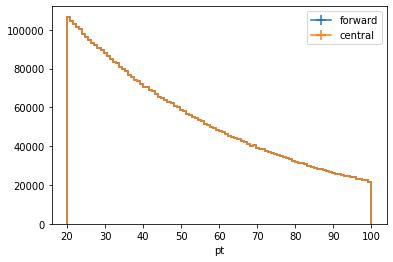

In [32]:
p_forward = h2d[{'eta': slice(1.5j, 3.0j)}][{'eta': sum}]
p_central = h2d[{'eta': slice(0j, 1.5j)}][{'eta': sum}]

fig, ax = plt.subplots(figsize=(6, 4))

p_forward.plot1d(ax=ax, label='forward')
p_central.plot1d(ax=ax, label='central')
ax.legend()


But strangely, this gives us two identical histograms. The reason for this is
that the histogram integration via the `sum` indicator sums over all bins on the
axis, including the overflow and underflow bins. After histogram slices, entries
are not so much removed, but rather they are merged to the underflow and
overflow bins of the new axis. One can check this simply by seeing that the
`p_forward` and `p_central` histograms declared above has the same number of
entries when considering all entries including the `flow` bins.

In [38]:
print(p_forward.__repr__())
print(p_central.__repr__())

Hist(Regular(100, 20, 100, name='pt', label='pt'), storage=Double()) # Sum: 350324.0 (5000980.0 with flow)
Hist(Regular(100, 20, 100, name='pt', label='pt'), storage=Double()) # Sum: 2319945.0 (6970601.0 with flow)


 

To integrate over a range, we will need to explicitly set the overflow and
underflow bin to zero. As the histogram value modification looks very much like
array value manipulation, the function to perform the integration should look
something like this:

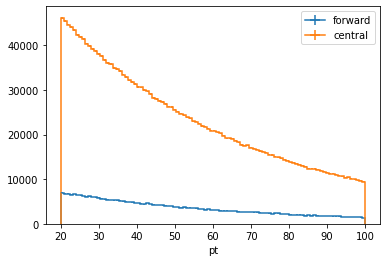

In [41]:
def int_range(h, axis_name, int_slice):
  h_slice = h[{axis_name: int_slice}]
  # This needs to be an array! Since the overbin slicing still gives you and
  # array!
  h_slice[{
    axis_name: hist.overflow
  }] = np.zeros_like(h_slice[{
    axis_name: hist.overflow
  }])
  h_slice[{
    axis_name: hist.underflow
  }] = np.zeros_like(h_slice[{
    axis_name: hist.underflow
  }])
  return h_slice[{axis_name: sum}]


p_forward = int_range(h2d, 'eta', slice(1.5j, 3.0j))
p_central = int_range(h2d, 'eta', slice(0j, 1.5j))
fig, ax = plt.subplots(figsize=(6, 4))

p_forward.plot1d(ax=ax, label='forward')
p_central.plot1d(ax=ax, label='central')
ax.legend()


Also notice how the axis underflow and overflow bins need to be accessed via a
special index value `hist.underflow` and `hist.overflow`. This is to save more
on the issue of whether the bin indices to break the computation convention of
starting at 0 to account for the underflow bins, as it does with ROOT.

## More axis types

Previously all, of our examples are done with the simple axis types of having
regular interval binning. Here let us familiarize ourselves with the other axis
types, and how these can also be used for the UHI notations:


In [43]:
hist.axis.Variable


hist.axis.Variable

The user provides the binning scheme ${x_i}$ in array format to be used for a
continuous variable, a slight word on how the slicing using the `j` postfix
interacts with the bin edges. For the slice request of $Aj$, the histogram will
find bin index $B$ such that $A \in [x_B, x_{B+1})$. Notice the boundary of the
values in question.


In [ ]:
hist.axis.StrCategory

The categorical axis. Notice that by default, the user should provide a list of
categories that the histogram should attempt to classify, and entries that
do not match the provided list will be placed in the overflow bin. If you want
the histogram to dynamically generate the categories on filling, declare with
axis with the `growth=True` options. For value-based-slicing, the user can
simply provide a single string or a list of string of the categories of
interest. Such as

```python
h[{'cat': 'A'}] # The cat axis is discarded as we are looking a since bin entry
h[{'cat': ['A', 'B']}] # The cat axis is kept, with just 2 valid entries  remaining.
```


## More fill types

Commonly in HEP analysis, we will need to construct histogram with weighted
entries. So do this, you will need to explicitly specify the storage of the
histogram to anticipate weights:

In [52]:
h = hist.Hist(hist.axis.Regular(50, -5, 5, name='x'),
              storage=hist.storage.Weight())
h.fill(x=np.random.normal(scale=2, size=1_000_000),
       weight=np.random.normal(loc=0.1, scale=0.01, size=1_000_000))


Hist(Regular(50, -5, 5, name='x', label='x'), storage=Weight()) # Sum: WeightedSum(value=98773.4, variance=9977.51) (WeightedSum(value=100013, variance=10102.5) with flow)

Now when you slice to a single bin value, you will notice that the return is
weight container:

In [48]:
h[{'x': 5}]

WeightedSum(value=609.873, variance=61.6699)

The values correspond to the sum of weight $sum_i w_i$ and the sum of weights
squared $sum_i w_i^2$ for that specified bin entry. You can access each element
using the usual index notation:


In [51]:
print(h[{'x': 5}])
print(h[{'x': 5}]['value'])
print(h[{'x': 5}]['variance'])

WeightedSum(value=609.873, variance=61.6699)
609.8726791968885
61.669854926889464
